# Лабораторная работа №2 (проведение исследований с алгоритмом LogisticRegression)

In [565]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

In [566]:
glass_dataset = fetch_ucirepo(id=42)

In [567]:
df = pd.DataFrame(data=glass_dataset.data.features)
df['Glass'] = glass_dataset.data.targets

In [568]:
target_column = "Glass"

class_names = [
    "building_windows_float_processed",
    "building_windows_non_float_processed",
    "vehicle_windows_float_processed",
    "vehicle_windows_non_float_processed",
    "containers",
    "tableware",
    "headlamps",
    ]

# df[target_column] = df[target_column].apply(lambda x: class_names[x-1])
# df[target_column].head()

Разобьем выборку на обучающую и валидационную

In [569]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df.drop(columns=[target_column], inplace=False), 
    df[target_column], 
    test_size=0.2, 
    random_state=42, 
    stratify=df[target_column]
    )

## 2. Создание бейзлайна и оценка качества

### Обучение модели

Определим модель и обучим модель

In [570]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Сделаем предсказания

In [571]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### Оценка качества модели

У нас мультиклассовая классификация, но класс `vehicle_windows_non_float_processed` отсутствует среди истинных меток классов

In [572]:
df[target_column].nunique()

6

Поэтому метрики будем вычислять, используя параметры `average='macro'` и `zero_division=1` 

In [573]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [574]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.586031,0.611495
1,Balanced Accuracy,0.571694,0.634921
2,Precision,0.782671,0.594551
3,Recall,0.571694,0.634921


Визуализируем метрики

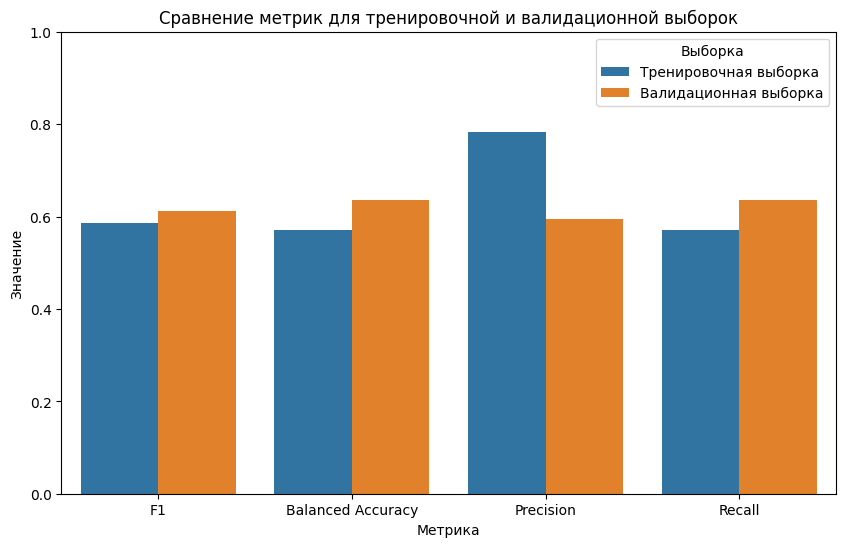

In [575]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

## 3. Улучшение бейзлайна

### Препроцессинг данных

In [576]:
df_optimized = df.copy()

In [577]:
# Обработка выбросов
def remove_outliers(data, columns, threshold=1.5):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

df_optimized = remove_outliers(df_optimized, df_optimized.columns)

In [578]:
X = df_optimized.drop(target_column, axis=1)
y = df_optimized[target_column]

Скалирование данных

In [579]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Балансировка классов

In [580]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [581]:
new_X_train, new_X_valid, new_y_train, new_y_valid = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
    )


Решим проблему высокой корреляции данных

In [582]:
pca = PCA(n_components=new_X_train.shape[1])
pca.fit(new_X_train)

PCA(n_components=9)

Проверим сколько компонент дают 90% дисперсии

In [583]:
pca.explained_variance_ratio_.round(2)

array([0.27, 0.23, 0.15, 0.13, 0.1 , 0.06, 0.05, 0.  , 0.  ])

Достаточно 7-и компонент

### Обучение модели с новыми данными

Переопределим модель

In [584]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", LogisticRegression())
))

In [585]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)), ('model', LogisticRegression())])

Сделаем предсказания

In [586]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### Оценка качетсва модели с улучшеным бейзлайном

In [587]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro')

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro')

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [588]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.820190,0.861404
1,Balanced Accuracy,0.826136,0.862963
2,Precision,0.826644,0.862963
3,Recall,0.826136,0.862963


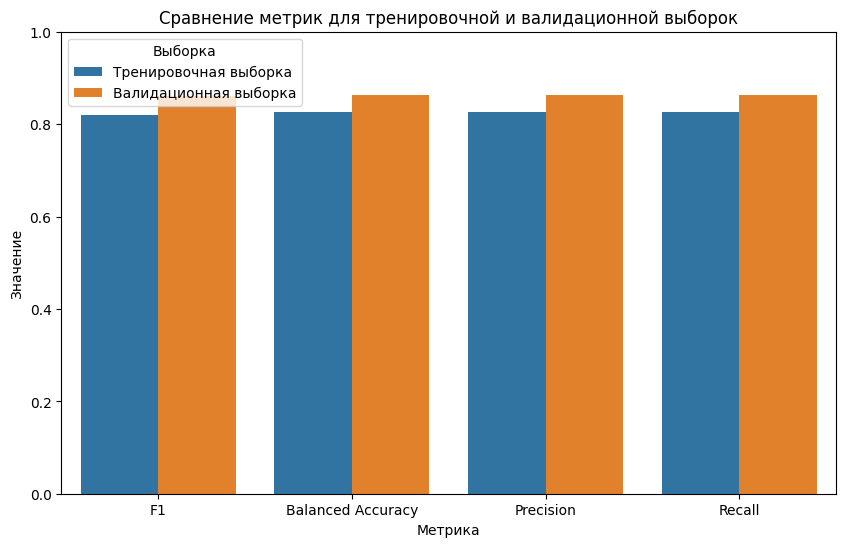

In [589]:
# Визуализация метрик
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Резюме:
На качество модели повлияли, как входные данные, так и параметры самой модели:
- При помощи квантилей я удалил выбросы
- Скалировал данные StandartScaller'ом
- Избавился от дисбалана классов
- Избавился от высокой кореляции фичей

## 4. Имплементация алгоритма машинного обучения

### Реализация модели

In [590]:
class LogisticRegressor:
    def __init__(self, learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.classes = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Стабильность вычислений
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        # Преобразование DataFrame в numpy массивы
        m, n = X.shape
        self.classes = np.unique(y)
        k = len(self.classes)  # Количество классов
        
        # One-hot encoding меток классов
        y_encoded = np.zeros((m, k))
        for i, label in enumerate(y):
            y_encoded[i, self.classes == label] = 1
        
        # Инициализация весов
        self.weights = np.zeros((n, k))
        
        # Градиентный спуск
        for _ in range(self.max_iter):
            logits = X @ self.weights  # Линейные комбинации
            probabilities = self.softmax(logits)  # Вероятности классов
            gradient = X.T @ (probabilities - y_encoded) / m  # Градиент ошибки
            self.weights -= self.learning_rate * gradient  # Шаг градиентного спуска

    def predict_proba(self, X):
        logits = X @ self.weights
        return self.softmax(logits)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return self.classes[np.argmax(probabilities, axis=1)]


### Обучение 

In [591]:
model = LogisticRegressor()
model.fit(X_train.to_numpy(), y_train.to_numpy())

In [592]:
train_predict = model.predict(X_train.to_numpy())
valid_predict = model.predict(X_valid.to_numpy())

###  Оценка качества модели

In [593]:
np.unique(train_predict, return_counts=True)

(array([1, 2], dtype=int64), array([157,  14], dtype=int64))

In [594]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(y_train, train_predict)
train_precision = precision_score(y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(y_train, train_predict, average='macro', zero_division=1)

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(y_valid, valid_predict)
valid_precision = precision_score(y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(y_valid, valid_predict, average='macro', zero_division=1)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
})

In [595]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.109859,0.123249
1,Balanced Accuracy,0.180328,0.188889
2,Precision,0.785638,0.785285
3,Recall,0.180328,0.188889


Визуализация

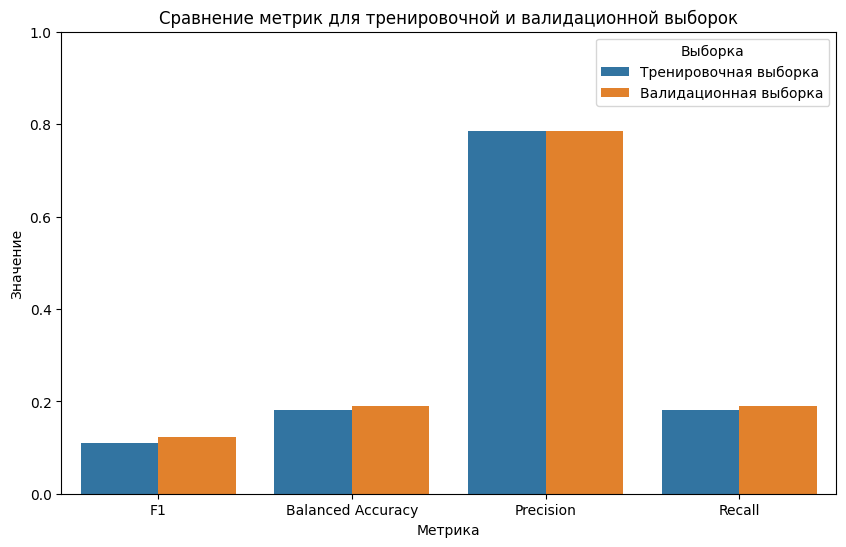

In [596]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()

### Обучение с улучшенным бейзлайном

In [597]:
model = Pipeline((
    ("pca", PCA(n_components=7)),
    ("model", LogisticRegressor())
))

In [598]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('pca', PCA(n_components=7)),
                ('model',
                 <__main__.LogisticRegressor object at 0x0000018EF21034F0>)])

In [599]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

###  Оценка качества модели

In [600]:
# Расчет метрик для тренировочных предсказаний
train_f1 = f1_score(new_y_train, train_predict, average='macro')
train_balanced_accuracy = balanced_accuracy_score(new_y_train, train_predict)
train_precision = precision_score(new_y_train, train_predict, average='macro', zero_division=1)
train_recall = recall_score(new_y_train, train_predict, average='macro', zero_division=1)

# Расчет метрик для валидационных предсказаний
valid_f1 = f1_score(new_y_valid, valid_predict, average='macro')
valid_balanced_accuracy = balanced_accuracy_score(new_y_valid, valid_predict)
valid_precision = precision_score(new_y_valid, valid_predict, average='macro', zero_division=1)
valid_recall = recall_score(new_y_valid, valid_predict, average='macro', zero_division=1)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['F1', 'Balanced Accuracy', 'Precision', 'Recall'],
    'Тренировочная выборка': [train_f1, train_balanced_accuracy, train_precision, train_recall],
    'Валидационная выборка': [valid_f1, valid_balanced_accuracy, valid_precision, valid_recall]
    })

In [601]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,F1,0.803672,0.859259
1,Balanced Accuracy,0.808817,0.862963
2,Precision,0.810508,0.867424
3,Recall,0.808817,0.862963


Визуализация

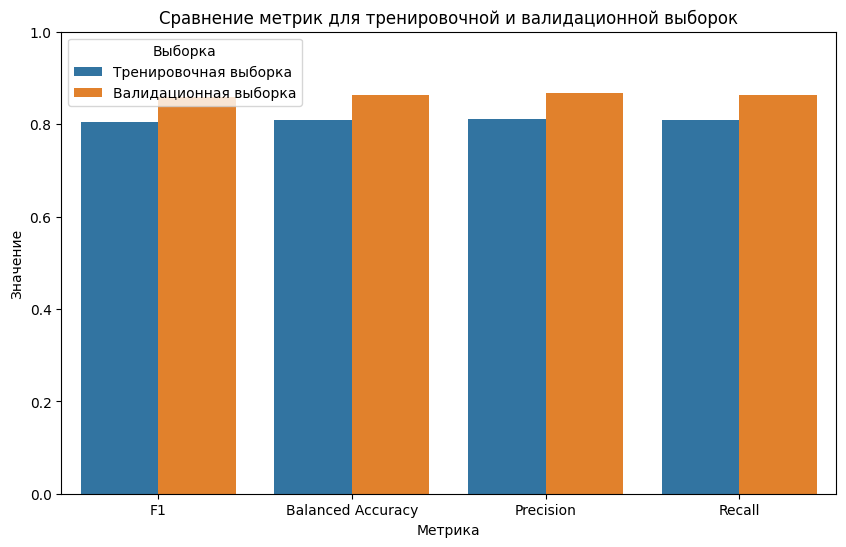

In [602]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Метрика', var_name='Выборка', value_name='Значение'),
            x='Метрика', y='Значение', hue='Выборка')
plt.title('Сравнение метрик для тренировочной и валидационной выборок')
plt.ylim(0, 1)
plt.legend(title='Выборка')
plt.show()